In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('C:\\Users\\Usuario\\TFG\\digipanca\\')

In [9]:
import torch
import random
import numpy as np
from src.models import CustomDeepLabV3 as CDL
from src.utils.config import load_config
from src.data.transforms import build_transforms_from_config
from src.data.dataset import PancreasDataset
from torch.utils.data import DataLoader
from scripts.eval import visualize_model_predictions

# __Load model checkpoint and set eval__

In [4]:
MODEL_PATH = 'experiments/deep_aug_randcrop/deep_aug_randcrop_20250319_074330/checkpoints/best_model_epoch21.pth'
model = CDL(num_classes=5, dropout_rate=0.2, pretrained=False)
checkpoint = torch.load(MODEL_PATH, map_location='cpu')['model']
model.load_state_dict(
    {k: v for k, v in checkpoint.items() if "aux_classifier" not in k},
    strict=False
)
model.eval();

In [21]:
config = load_config('configs/experiments/deep_aug_randcrop.yaml')
transform = build_transforms_from_config(config.get('transforms', None))
val_dataset = PancreasDataset(
    data_dir=config['data']['raw_dir'],
    split_file=config['data']['split_path'],
    split_type='val',
    transform=transform
)

📊 Loading dataset (val)... 12 patients found.
📊 Dataset loaded with 1305 slices.


In [22]:
val_loader = DataLoader(
    val_dataset,
    batch_size=4,
    shuffle=False,
    num_workers=config['data']['num_workers'],
    pin_memory=True
)

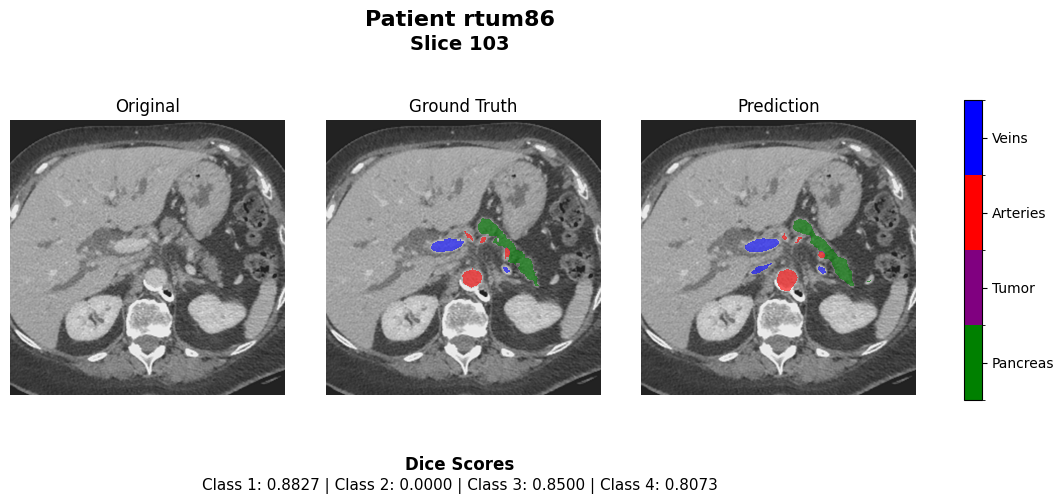

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
visualize_model_predictions(model, val_loader, device, 1)

# __Functions__

## `convert_to_one_hot`

In [12]:
def convert_to_one_hot(y_pred, y_true):
    def is_one_hot(tensor):
        """
        Check if the tensor is one-hot encoded.
        """
        return (tensor.sum(dim=1) == 1).all() and \
               torch.all((tensor == 0) | (tensor == 1))
    
    # Check if the input is already one-hot encoded
    if is_one_hot(y_pred) and is_one_hot(y_true):
        return y_pred, y_true
    
    # Check if the input is 2D or 3D
    if y_pred.dim() == 4 and y_true.dim() == 3: # 2D case
        B, C, H, W = y_pred.shape
        n_classes = C

        # Convert y_pred to one-hot encoding
        y_pred_classes = torch.argmax(y_pred, dim=1, keepdim=True)
        y_pred_one_hot = torch.zeros(B, n_classes, H, W, device=y_pred.device)
        y_pred_one_hot.scatter_(1, y_pred_classes, 1)

        # Convert y_true to one-hot encoding
        y_true_one_hot = torch.zeros(B, n_classes, H, W, device=y_true.device)
        y_true_one_hot.scatter_(1, y_true.unsqueeze(1).long(), 1)

        return y_pred_one_hot, y_true_one_hot
    
    elif y_pred.dim() == 5 and y_true.dim() == 4:   # 3D case
        B, C, D, H, W = y_pred.shape
        n_classes = C

        # Convert y_pred to one-hot encoding
        y_pred_classes = torch.argmax(y_pred, dim=1, keepdim=True)
        y_pred_one_hot = torch.zeros(B, n_classes, D, H, W, device=y_pred.device)
        y_pred_one_hot.scatter_(1, y_pred_classes, 1)

        # Convert y_true to one-hot encoding
        y_true_one_hot = torch.zeros(B, n_classes, D, H, W, device=y_true.device)
        y_true_one_hot.scatter_(1, y_true.unsqueeze(1).long(), 1)

        return y_pred_one_hot, y_true_one_hot

    else:
        raise ValueError("Input tensors must be either 2D or 3D.")

## `dice_mean`

In [59]:
def dice_mean(y_pred, y_true, smooth=1e-5, verbose=False):
    # Convert to one-hot if inputs are class indices or logits
    y_pred_one_hot, y_true_one_hot = convert_to_one_hot(y_pred, y_true)
    C = y_true_one_hot.size(1)
    sum_dims = tuple(range(2, y_true_one_hot.ndim))
    
    # Compute intersection and union
    intersection = torch.sum(y_pred_one_hot * y_true_one_hot, dim=sum_dims)
    union = torch.sum(y_pred_one_hot, dim=sum_dims) \
          + torch.sum(y_true_one_hot, dim=sum_dims)

    # Compute Dice score
    dice_scores = 2. * intersection / (union + smooth)
    if verbose:
        print(f"dice_mean before mean:\n{dice_scores}")
    dice_scores = dice_scores.mean(dim=0)
    if verbose:
        print(f"dice_mean after mean:\n{dice_scores}")

    dice_dict = {f"dice_class_{i}": dice_scores[i].item() for i in range(C)}
    dice_dict["dice_mean"] = dice_scores.mean().item()
    
    return dice_scores.mean(), dice_dict

## `dice_mean_v2`

In [116]:
def dice_mean_v2(y_pred, y_true, smooth=1e-5, verbose=False):
    # Convert to one-hot if inputs are class indices or logits
    y_pred_one_hot, y_true_one_hot = convert_to_one_hot(y_pred, y_true)
    C = y_true_one_hot.size(1)
    sum_dims = tuple(range(2, y_true_one_hot.ndim))
    
    # Compute intersection and union
    intersection = torch.sum(y_pred_one_hot * y_true_one_hot, dim=sum_dims)
    union = torch.sum(y_pred_one_hot, dim=sum_dims) + torch.sum(y_true_one_hot, dim=sum_dims)

    # Compute Dice per class
    dice_scores = 2. * intersection / (union + smooth)

    # Asignar NaN a clases vacías (union == 0)
    dice_scores[torch.sum(y_true_one_hot, dim=sum_dims) == 0] = float('nan')
    if verbose:
        print(f"dice_mean before mean:\n{dice_scores}")
    # Promedio ignorando NaNs
    dice_mean = torch.nanmean(dice_scores, dim=0)
    if verbose:
        print(f"dice_mean after mean:\n{dice_mean}")

    # Diccionario con resultados por clase
    dice_dict = {f"dice_class_{i}": dice_mean[i].item() for i in range(C)}
    dice_dict["dice_mean"] = torch.nanmean(dice_mean).item()

    return dice_dict["dice_mean"], dice_dict

## `dice_sum`

In [55]:
def dice_sum(y_pred, y_true, smooth=1e-5, verbose=False):
    # Convert to one-hot
    y_pred_one_hot, y_true_one_hot = convert_to_one_hot(y_pred, y_true)
    C = y_true_one_hot.size(1)
    sum_dims = tuple(range(2, y_true_one_hot.ndim))  # dimensions other than (B, C)

    # Compute intersection and union
    intersection = torch.sum(y_pred_one_hot * y_true_one_hot, dim=sum_dims)  # (B, C)
    union = torch.sum(y_pred_one_hot, dim=sum_dims) + torch.sum(y_true_one_hot, dim=sum_dims)  # (B, C)

    # Sum over batch for global metrics
    intersection = intersection.sum(dim=0)  # (C,)
    union = union.sum(dim=0)  # (C,)

    dice_scores = 2. * intersection / (union + smooth)  # (C,)
    if verbose:
        print(f"dice_sum:\n{dice_scores}")

    dice_dict = {f"dice_class_{i}": dice_scores[i].item() for i in range(C)}
    dice_dict["dice_mean"] = dice_scores.mean().item()

    return dice_scores.mean(), dice_dict

## `dice_monai`

In [56]:
def dice_monai(y_pred, y_true, verbose=False):
    from monai.metrics import DiceMetric
    dmm = DiceMetric(
        include_background=True,
        reduction='mean_batch',
        get_not_nans=False,
        ignore_empty=True,
        num_classes=None,
        return_with_label=False
    )
    y_pred_one_hot, y_true_one_hot = convert_to_one_hot(y_pred, y_true)
    C = y_true_one_hot.size(1)
    start = 0
    monai_dice = dmm(y_pred_one_hot, y_true_one_hot)
    if verbose:
        print(f"dice_monai before aggregate:\n{monai_dice}")

    monai_dice = dmm.aggregate()
    if verbose:
        print(f"dice_monai after aggregate:\n{monai_dice}")

    dice_dict = {f"dice_class_{i}": monai_dice[i].item() for i in range(start, C)}
    dice_dict["dice_mean"] = monai_dice.mean().item()
    
    return monai_dice.mean(), dice_dict

## `test_prediction_scores`

In [47]:
def test_prediction_scores(output, masks):

    # Compute Dice Score for each class
    mdm, dice_scores_mean = dice_mean(output, masks)
    mds, dice_scores_sum = dice_sum(output, masks)
    mdmonai, dice_scores_monai = dice_monai(output, masks)

    print(f"DICE SCORES")
    class_names = {
        0: 'Background',
        1: 'Pancreas',
        2: 'Tumor',
        3: 'Arteries',
        4: 'Veins'
    }
    print(f"{'Class':<10}{'Mean':>15}{'Sum':>15}{'MONAI':>15}")
    print("-" * 65)

    for idx in class_names:
        key = f'dice_class_{idx}'
        dmean = np.round(dice_scores_mean[key], 5)
        dsum = np.round(dice_scores_sum[key], 5)
        dmonai = np.round(dice_scores_monai[key], 5)

        print(f"{class_names[idx]:<10}{dmean:>15,}{dsum:>15,}{dmonai:>15,}")

    print(f"{'Media':<10}{np.round(mdm.item(), 5):>15,}{np.round(mds.item(), 5):>15,}{np.round(mdmonai.item(), 5):>15,}")

## `generate_predictions`

In [41]:
def generate_predictions(model, test_loader, device):
    model.eval()

    # for i, idx in enumerate(indices):
    with torch.no_grad():
        for image, mask, _ in test_loader: 
            image, mask = image.to(device), mask.to(device)

            output = model(image)["out"]
            print(f"Ouptut shape: {output.shape}")
            print(f"Mask shape: {mask.shape}")

            return output, mask

## `check_presence`

In [101]:
def check_presence(y_pred, y_true):
    pred, gt = convert_to_one_hot(y_pred, y_true)
    B = gt.size(0)
    C = gt.size(1)

    print(f"{'INDEX':<10}{'PANCREAS':<14}{'TUMOR':<14}{'ARTERIES':<14}{'VEINS':<14}")
    print(f"{'':<10}{'Pred':<7}{'Mask':<7}{'Pred':<7}{'Mask':<7}{'Pred':<7}{'Mask':<7}{'Pred':<7}{'Mask':<7}")
    print("-" * 65)

    for i in range(B):
        pa = pred[i, 1, ...].any() == 1.
        pb = gt[i, 1, ...].any() == 1.
        ta = pred[i, 2, ...].any() == 1.
        tb = gt[i, 2, ...].any() == 1.
        aa = pred[i, 3, ...].any() == 1.
        ab = gt[i, 3, ...].any() == 1.
        va = pred[i, 4, ...].any() == 1.
        vb = gt[i, 4, ...].any() == 1.
        print(f"{i:<10}{pa:<7}{pb:<7}{ta:<7}{tb:<7}{aa:<7}{ab:<7}{va:<7}{vb:<7}")

# __Testing__

In [43]:
output, masks = generate_predictions(model, val_loader, device)

Ouptut shape: torch.Size([4, 5, 512, 512])
Mask shape: torch.Size([4, 512, 512])


In [48]:
test_prediction_scores(output, masks)

DICE SCORES
Class                Mean            Sum          MONAI
-----------------------------------------------------------------
Background        0.99613        0.99612        0.99613
Pancreas              0.0            0.0            0.0
Tumor                 0.0            0.0            0.0
Arteries              0.0            0.0            0.0
Veins              0.4442        0.61023         0.8884
Media             0.28807        0.32127         0.3769


In [49]:
monai_scores = dice_monai(output, masks)
print(monai_scores)

(tensor(0.3769), {'dice_class_0': 0.9961274862289429, 'dice_class_1': 0.0, 'dice_class_2': 0.0, 'dice_class_3': 0.0, 'dice_class_4': 0.8883956670761108, 'dice_mean': 0.3769046366214752})


In [102]:
check_presence(output, masks)

INDEX     PANCREAS      TUMOR         ARTERIES      VEINS         
          Pred   Mask   Pred   Mask   Pred   Mask   Pred   Mask   
-----------------------------------------------------------------
0         1      0      0      0      1      0      1      0      
1         0      0      1      0      1      0      1      0      
2         1      0      1      0      1      0      1      1      
3         1      0      0      0      1      0      1      1      


In [137]:
print('-'*80)
mean_scores = dice_mean(output, masks, verbose=True)
print('-'*80)
sum_scores = dice_sum(output, masks, verbose=True)
print('-'*80)
monai_scores = dice_monai(output, masks, verbose=True)
print('-'*80)
mean_scores = dice_mean_v2(output, masks, verbose=True)
print(mean_scores)

--------------------------------------------------------------------------------
dice_mean before mean:
tensor([[0.9949, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9948, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.9973, 0.0000, 0.0000, 0.0000, 0.8699],
        [0.9974, 0.0000, 0.0000, 0.0000, 0.9069]])
dice_mean after mean:
tensor([0.9961, 0.0000, 0.0000, 0.0000, 0.4442])
--------------------------------------------------------------------------------
dice_sum:
tensor([0.9961, 0.0000, 0.0000, 0.0000, 0.6102])
--------------------------------------------------------------------------------
dice_monai before aggregate:
tensor([[0.9949,    nan,    nan,    nan,    nan],
        [0.9948,    nan,    nan,    nan,    nan],
        [0.9973,    nan,    nan,    nan, 0.8699],
        [0.9974,    nan,    nan,    nan, 0.9069]])
dice_monai after aggregate:
tensor([0.9961, 0.0000, 0.0000, 0.0000, 0.8884])
--------------------------------------------------------------------------------
dice_mean befor

In [61]:
from src.metrics.segmentation_bak import SegmentationMetrics as smbak

In [64]:
y_pred_1h, y_true_1h = convert_to_one_hot(output, masks)

In [65]:
dice_bak = smbak.dice_coefficient(y_pred_1h, y_true_1h)
print(dice_bak)

(tensor(0.3213), {'dice_class_0': 0.9961248636245728, 'dice_class_1': 7.092198384128778e-09, 'dice_class_2': 1.515151559772221e-08, 'dice_class_3': 3.0111413362732264e-10, 'dice_class_4': 0.6102335453033447, 'dice_mean': 0.321271687746048})


# __Getting not nans__

In [131]:
def dice_monai_nn(y_pred, y_true, verbose=False):
    from monai.metrics import DiceMetric
    dmm = DiceMetric(
        include_background=True,
        reduction='mean_batch',
        get_not_nans=True,
        ignore_empty=True,
        num_classes=None,
        return_with_label=False
    )
    y_pred_one_hot, y_true_one_hot = convert_to_one_hot(y_pred, y_true)
    C = y_true_one_hot.size(1)
    start = 0
    monai_dice = dmm(y_pred_one_hot, y_true_one_hot)
    if verbose:
        print(f"dice_monai before aggregate:\n{monai_dice}")

    monai_dice, notnans = dmm.aggregate()
    if verbose:
        print(f"dice_monai after aggregate:\n{monai_dice}")
        print(f"notnans: {notnans} | {sum(notnans>0)}")

    dice_dict = {f"dice_class_{i}": monai_dice[i].item() for i in range(start, C)}
    dice_dict["dice_mean"] = monai_dice.mean().item()
    
    return monai_dice.mean(), dice_dict

In [132]:
monai_scores = dice_monai_nn(output, masks, verbose=True)

dice_monai before aggregate:
tensor([[0.9949,    nan,    nan,    nan,    nan],
        [0.9948,    nan,    nan,    nan,    nan],
        [0.9973,    nan,    nan,    nan, 0.8699],
        [0.9974,    nan,    nan,    nan, 0.9069]])
dice_monai after aggregate:
tensor([0.9961, 0.0000, 0.0000, 0.0000, 0.8884])
notnans: tensor([4., 0., 0., 0., 2.]) | 2
